## Shap values for aerobic/anaerobic and OGT phenotypes

### 1. Shap values for OGT phenotype

In [13]:
import os
import sys

import shap
import torch

import pandas as pd

# Add the parent directory to the sys.path if it's not already there
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from set_transformer.set_transformer_architecture import SetTransformer, SetTransformerWrapper


Load the pre-trained model for the specified parameters

In [4]:
# Starting with OGT phenotype
phenotype = "ogt"
discret = "discrete_predict"
model_name = "SetTransformer"

# Define all params of the pre-trained model to load
ind_point = 10
D = 3165
K = 1
dim_output = 50
save_path = f"{parent_dir}/results/{model_name}/{phenotype}/{discret}/trained_models/trained_model_{model_name}_indPoints_{ind_point}_D_{D}_K_{K}_dim_output_{dim_output}.model" 

loaded_model = SetTransformer(D, K, dim_output)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(save_path, weights_only=True))

<All keys matched successfully>

In [5]:
output_class = 0  # Specify the class index you want to explain
wrapped_model = SetTransformerWrapper(loaded_model, output_class)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model = wrapped_model.to(device)

In [7]:
from set_transformer.main import read_ogt_data
ogt_continuous_flag = False
# Read the initial train and test data
if phenotype == "ogt":
    X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, num_classes = read_ogt_data(device, dim_output, ogt_continuous_flag)

X_train = X_train.to(device)
X_test = X_test.to(device)

In [12]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np 

estimator = RandomForestRegressor()
boruta = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100)

boruta.fit(np.array(X_train), np.array(y_train))

important = list(X.columns[boruta.support_])

KeyboardInterrupt: 

In [9]:
# Calculate the SHAP values
explainer = shap.DeepExplainer(wrapped_model, X_train.unsqueeze(1))
shap_values = explainer.shap_values(X_test.unsqueeze(1), check_additivity=False)

shap_values = shap_values.squeeze(1)

print(f"Shape of shap_values: {shap_values.shape}")

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


KeyboardInterrupt: 

In [ ]:
# For visualization, you can extract SHAP values for a specific class if needed
shap_values_class_0 = shap_values[:, :, 0]  # For class 0 (first class)
print(f"Shape of shap_values_class_0: {shap_values_class_0.shape}")

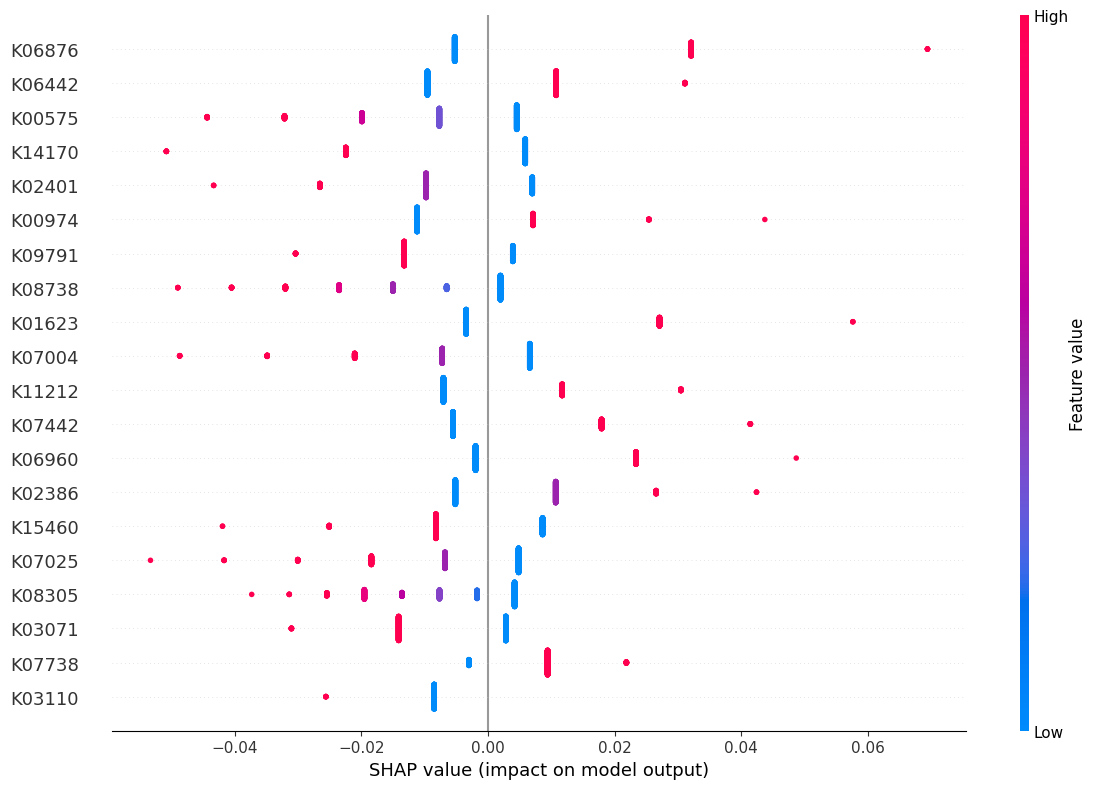

In [6]:
# Plot the SHAP values
shap.summary_plot(shap_values_class_0, X_test.cpu().numpy(), max_display=20, feature_names=X_test_column_names, plot_size=(12, 8))


In [2]:
import numpy as np

# Find the top 20 SHAP values and the corresponding features
mean_abs_shap_values = np.abs(shap_values_class_0).mean(axis=0)
top_20_indices = np.argsort(mean_abs_shap_values)[-20:][::-1]
top_20_features = [(kos_and_names_column_names[i], mean_abs_shap_values[i]) for i in top_20_indices]

print("Top 20 features with the highest SHAP values:\n")
for feature_name, shap_value in top_20_features:
    print(f"{feature_name}: {shap_value:.4f}")

NameError: name 'shap_values_class_0' is not defined

### 2. Shap values for aerobic/anaerobic phenotype

In [8]:
model_name = "SetTransformer"
phenotype = "aerob"
ind_point = 4
D = 2677
K = 1
dim_output = 1
save_path = f"{parent_dir}/results/{model_name}/{phenotype}/trained_models/trained_model_{model_name}_indPoints_{ind_point}_D_{D}_K_{K}_dim_output_{dim_output}.model" 

#save_path = f"set_transformer/resuls_SetTransformer/trained_models/trained_model_{model_name}_phenotype_{phenotype}_indPoints_{ind_point}_D_{D}_K_{K}_dim_output_{dim_output}.model" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model_aerob = SetTransformer(D, K, dim_output)
loaded_model_aerob.to(device)

# Load the saved state dictionary
loaded_model_aerob.load_state_dict(torch.load(save_path, weights_only=True))

<All keys matched successfully>

In [12]:
from utils.utils import process_aerob_dataset

data_filename_train = '../data_aerob/all_gene_annotations.added_incompleteness_and_contamination.subsampled.training.tsv' 
data_filename_test = '../data_aerob/all_gene_annotations.added_incompleteness_and_contamination.subsampled.testing.tsv'
y_filename = '../data_aerob/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv'

if phenotype == "aerob":
    X_train, X_train_column_names, y_train, d_gtdb_train = process_aerob_dataset(data_filename_train, y_filename, device)
    X_test, X_test_column_names, y_test, d_gtdb_test = process_aerob_dataset(data_filename_test, y_filename, device)
    num_classes = 2

print(X_train.shape)    
print(X_test.shape) 

X_train = X_train.to(device)
X_test = X_test.to(device)

Counts of each class in training/test data: shape: (2, 2)
┌──────────────┬───────┐
│ oxytolerance ┆ len   │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ aerobe       ┆ 29808 │
│ anaerobe     ┆ 29808 │
└──────────────┴───────┘
Counts of each class in training/test data: shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ str          ┆ u32  │
╞══════════════╪══════╡
│ anaerobe     ┆ 8172 │
│ aerobe       ┆ 8172 │
└──────────────┴──────┘
torch.Size([59616, 2677])
torch.Size([16344, 2677])


In [13]:
modal_keggs = pd.read_csv('../data_aerob/modal_keggs_with_names.csv',sep="\t")
modal_keggs.index = modal_keggs['cog']
 
columns2 = pd.Series(['{} {} {}'.format(cog, ko, ko_name) for cog, ko, ko_name in zip(modal_keggs.loc[X_test_column_names,'cog'], modal_keggs.loc[X_test_column_names,'ko'], modal_keggs.loc[X_test_column_names,'ko_name'])])
dup_columns = columns2.duplicated()
columns2 = ["{}_{}".format(c,i) if is_dup else c for c,i,is_dup in zip(columns2, range(len(columns2)), dup_columns)]
kos_and_names_column_names = [c.replace('[', '').replace(']', '').replace('<', '_') for c in columns2]

In [ ]:
explainer = shap.DeepExplainer(loaded_model_aerob, X_train.unsqueeze(1))
shap_values = explainer.shap_values(X_test.unsqueeze(1), check_additivity=False)

shap_values = shap_values.squeeze(1)

print(f"Shape of shap_values: {shap_values.shape}")
print(f"Shape of X_test[:1000]: {X_test.shape}")

# For visualization, you can extract SHAP values for a specific class if needed
shap_values_class_0 = shap_values[:, :, 0]  # For class 0 (first class)
print(f"Shape of shap_values_class_0: {shap_values_class_0.shape}")

C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [ ]:
shap.summary_plot(shap_values_class_0, X_test.cpu().numpy(), max_display=20, feature_names=X_test_column_names, plot_size=(12, 8))

In [57]:
import numpy as np

mean_abs_shap_values = np.abs(shap_values_class_0).mean(axis=0)
top_20_indices = np.argsort(mean_abs_shap_values)[-20:][::-1]
top_20_features = [(kos_and_names_column_names[i], mean_abs_shap_values[i]) for i in top_20_indices]

print("Top 20 features with the highest SHAP values:\n")
for feature_name, shap_value in top_20_features:
    print(f"{feature_name}: {shap_value:.4f}")

Top 20 features with the highest SHAP values:

COG1012 K00135 succinate-semialdehyde dehydrogenase / glutarate-semialdehyde dehydrogenase EC:1.2.1.16 1.2.1.79 1.2.1.20: 0.0150
COG3173 K11729 acyl-CoA dehydrogenase family member 10: 0.0114
COG0467 K08482 circadian clock protein KaiC: 0.0103
COG2335 K19519 transforming growth factor-beta-induced protein: 0.0097
COG3324 K06996 uncharacterized protein: 0.0094
COG1350 K06001 tryptophan synthase beta chain EC:4.2.1.20: 0.0093
COG0508 K00627 pyruvate dehydrogenase E2 component (dihydrolipoamide acetyltransferase) EC:2.3.1.12: 0.0090
COG0243 K08352 thiosulfate reductase / polysulfide reductase chain A EC:1.8.5.5: 0.0085
COG4618 K12536 ATP-binding cassette, subfamily C, type I secretion system permease/ATPase: 0.0084
COG0400 K06999 phospholipase/carboxylesterase: 0.0084
COG0754 K01460 glutathionylspermidine amidase/synthetase EC:3.5.1.78 6.3.1.8: 0.0082
COG1252 K03885 NADH:quinone reductase (non-electrogenic) EC:1.6.5.9: 0.0082
COG0225 K07304 p